In [1]:
# Imporing required Packages/Modules
import os
import tensorflow as tf
import datetime
import numpy as np # For array-related manipulations
import pandas as pd # For DataFrame-related operations 
import matplotlib.pyplot as plt # Useful for graph plotting
import seaborn as sns # Another easy graph module
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Will be used for model evaluation
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, load_model # Base class for most Neural Networks
from keras.optimizers import Adam # Model Optimizer for Model fitting
from keras.utils import to_categorical # For converting label to categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.svm import SVC

In [3]:
# Google Colab Runtime
# from google.colab import drive
# drive.mount('/content/drive/')
# data_dir = "/content/drive/MyDrive/xPLNet/"
# os.chdir(data_dir)

# Local Runtime
data_dir = "Sugarcane Leaf Image Dataset"

### Data Augmentation and Data Generation using Image Data Generator

In [4]:
Data_Generator = ImageDataGenerator(featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    rotation_range=2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    rescale=1./255,
                                    validation_split=0.2)

train_set = Data_Generator.flow_from_directory(directory=data_dir + 'Training Samples/',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               subset='training')


val_set = Data_Generator.flow_from_directory(directory=data_dir + 'Training Samples/',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               subset='validation')

test_set = ImageDataGenerator(featurewise_center=False,
                              samplewise_center=False,
                              featurewise_std_normalization=False,
                              samplewise_std_normalization=False,
                              rotation_range=0,
                              width_shift_range=0,
                              height_shift_range=0,
                              horizontal_flip=False,
                              vertical_flip=False,
                              rescale=1./255).flow_from_directory(directory=data_dir + 'Test Samples/',
                                                                  target_size=(224, 224),
                                                                  class_mode='categorical',
                                                                  batch_size=8,
                                                                  shuffle=False)

Found 47351 images belonging to 9 classes.
Found 11833 images belonging to 9 classes.
Found 5114 images belonging to 9 classes.


1. Define a CNN model for feature extraction
2. Train the CNN model on a training set of images
3. Extract features from the training images using the trained CNN model
4. Train an SVM classifier on the extracted features and their corresponding labels
5. For each test image, extract features using the trained CNN model
6. Use the trained SVM classifier to predict the label of the test image based on its features

### Model Creation

In [5]:
intellect = Sequential()
intellect.add(Conv2D(128, kernel_size=(3,3), input_shape=((train_set.target_size) + (3,)), activation='relu'))
intellect.add(Conv2D(128, (3,3), activation='relu'))
intellect.add(Dropout(0.2))
intellect.add(MaxPooling2D(2,2))
intellect.add(Conv2D(64, (3,3), activation='relu'))
intellect.add(Conv2D(64, (3,3), activation='relu'))
intellect.add(Dropout(0.2))
intellect.add(MaxPooling2D(2,2))
intellect.add(Flatten())
intellect.add(Dense(64, activation='relu'))
intellect.add(Dropout(0.1))
intellect.add(Dense(train_set.class_indices.__len__(), activation='softmax'))

In [5]:
intellect.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
intellect.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 128)     147584    
                                                                 
 dropout (Dropout)           (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 64)      36928     
                                                        

In [7]:
# CALLBACKS
%load_ext tensorboard
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = ModelCheckpoint(f'CNN-SVM-model-{datetime.datetime.now().__format__("%Y-%m-%d-%H-%M-%S")}.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

#Tensorboard
current_time = datetime.datetime.now().__format__('%Y-%m-%d-%H-%M-%S')
tb_callback = TensorBoard(log_dir=f"./logs/CNN-SVM-model-{current_time}", histogram_freq=2)

In [8]:
CNN_history = intellect.fit(train_set, epochs=20, validation_data=val_set, verbose=1, callbacks=[lr_reduce, checkpoint, tb_callback, early_stop])

Epoch 1/20
5919/5919 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.4949
Epoch 1: val_accuracy improved from -inf to 0.66948, saving model to CNN-SVM-model-2023-04-24-13-06-03.h5
5919/5919 [==============================] - 1230s 207ms/step - loss: 1.3854 - accuracy: 0.4949 - val_loss: 1.0009 - val_accuracy: 0.6695 - lr: 1.0000e-04
Epoch 2/20
5919/5919 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.6700
Epoch 2: val_accuracy improved from 0.66948 to 0.72002, saving model to CNN-SVM-model-2023-04-24-13-06-03.h5
5919/5919 [==============================] - 1070s 181ms/step - loss: 0.9247 - accuracy: 0.6700 - val_loss: 0.8521 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 3/20
5919/5919 [==============================] - ETA: 0s - loss: 0.7767 - accuracy: 0.7225
Epoch 3: val_accuracy improved from 0.72002 to 0.76726, saving model to CNN-SVM-model-2023-04-24-13-06-03.h5
5919/5919 [==============================] - 991s 167ms/step - loss: 0.7

### CNN Model Evaluation

Text(0.5, 1.0, 'Baseline CNN Model Accuracy')

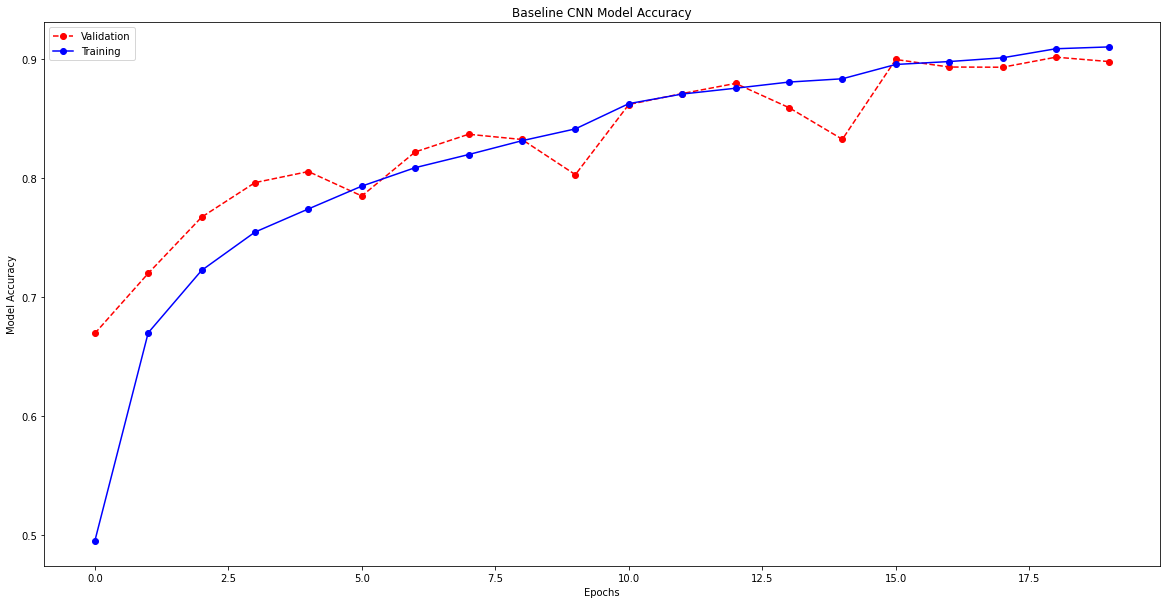

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(CNN_history.history['val_accuracy'], '--or', label="Validation")
plt.plot(CNN_history.history['accuracy'], "-ob", label="Training")
plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend(loc="upper left")
plt.title("Baseline CNN Model Accuracy")

Text(0.5, 1.0, 'Baseline CNN Model Loss per Epoch')

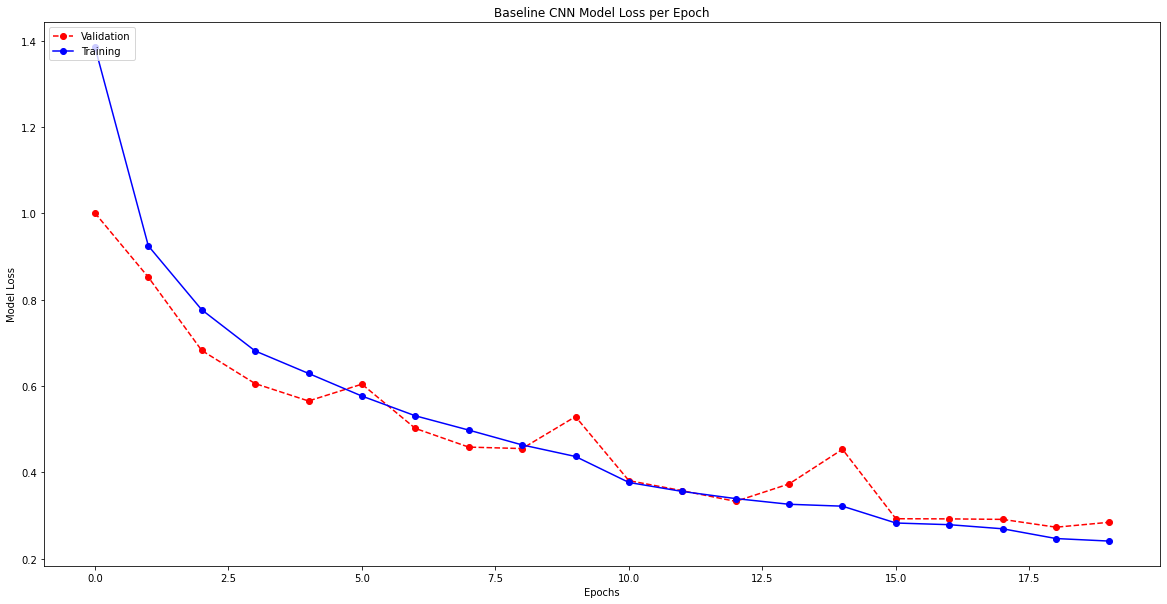

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(CNN_history.history['val_loss'], '--or', label="Validation")
plt.plot(CNN_history.history['loss'], "-ob", label="Training")
plt.xlabel("Epochs")
plt.ylabel("Model Loss")
plt.legend(loc="upper left")
plt.title("Baseline CNN Model Loss per Epoch")

##### CNN Model Evaluation using Test Data

In [6]:
"""
Importing the last save model by the ModelCheckpoint Callback
"""
intellect = load_model("./CNN-SVM-model-2023-04-24-13-06-03.h5")

In [7]:
CNN_pred_acc = intellect.evaluate(test_set)


640/640 [==============================] - 65s 90ms/step - loss: 0.1649 - accuracy: 0.9521


In [6]:
print("="*75)
print(f"|| Model Accuracy on Test Data: {CNN_pred_acc[1]*100:.3f}%")
print("="*75)
print("|| Model Loss on Test Data:", CNN_pred_acc[0])
print("="*75)

|| Model Accuracy on Test Data: 95.209%
|| Model Loss on Test Data: 0.1648794710636139


### Building Hybrid CNN-SVM Model

#### Extracting Features from CNN Model

In [8]:
train_features = intellect.predict(train_set)
validation_features = intellect.predict(val_set)

1480/1480 [==============================] - 227s 153ms/step


#### Training and Testing with the Support Vector Machine (SVM)

In [9]:
SVCM = SVC(kernel='rbf', gamma=0.01, C = 10, probability=True).fit(train_features, train_set.classes)

In [10]:
accuracy_score(SVCM.predict(validation_features), val_set.classes)

0.9127017662469366

#### Testing CNN-SVM model using Test Data

In [16]:
import pickle
file = 'SVCM.sav'
pickle.dump(SVCM, open(file, 'wb'))
SVCM = pickle.load(open(file, 'rb'))

In [14]:
test_features = intellect.predict(test_set)

640/640 [==============================] - 53s 83ms/step


In [17]:
print("="*75)
print(f"|| Accuracy Score of CNN-SVM on Test Data: {accuracy_score(SVCM.predict(test_features), test_set.classes)*100:.3f}%")
print("="*75)

|| Accuracy Score of CNN-SVM on Test Data: 95.053%


#### Improving the CNN-SVM Model using Grid Search

In [12]:
#Grid Search Parameters
param_grid = {'C': [0.1,1, 100], 'gamma': [1,0.01,0.001], 'kernel': ['rbf']} 
#Grid Search Execution
grid = GridSearchCV(SVC(),param_grid,verbose=3, n_jobs=-1).fit(train_features, train_set.classes)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [13]:
grid.best_estimator_

SVC(C=100, gamma=1)

#### Retesting CNN-SVM using optimized Parameters

In [14]:
SVCM = SVC(kernel='rbf', gamma=1, C = 100, probability=True).fit(train_features, train_set.classes)

In [15]:
accuracy_score(SVCM.predict(validation_features), val_set.classes)

0.9186174258429814

In [16]:
print("="*75)
print(f"|| Accuracy Score of CNN-SVM on Test Data: {accuracy_score(SVCM.predict(test_features), test_set.classes)*100:.3f}%")
print("="*75)

|| Accuracy Score of CNN-SVM on Test Data: 95.659%


### Hybrid CNN-SVM and CNN-SOFTMAX Metrics and Evaluation

#### Acquiring Predictions

In [17]:
SVCMPred = SVCM.predict(test_features)

In [39]:
CNNPred = np.argmax(test_features, axis=1)

#### Training and Testing Accuracy

In [48]:
print("="*75)
print(f"|| Training Accuracy Score of CNN-SVM: {accuracy_score(SVCM.predict(train_features), train_set.classes)*100:.3f}%")
print("="*75)
print(f"|| Testing Accuracy Score of CNN-SVM: {accuracy_score(SVCM.predict(test_features), test_set.classes)*100:.3f}%")
print("="*75)

|| Training Accuracy Score of CNN-SVM: 92.773%
|| Testing Accuracy Score of CNN-SVM: 95.659%


In [ ]:
print("="*75)
print(f"|| Training Accuracy Score of CNN-SOFTMAX: {accuracy_score(SVCM.predict(train_features), test_set.classes)*100:.3f}%")
print("="*75)
print(f"|| Testing Accuracy Score of CNN-SOFTMAX: {accuracy_score(SVCM.predict(test_features), test_set.classes)*100:.3f}%")
print("="*75)

#### Classification Report

##### CNN-SVM

In [20]:
print(classification_report(SVCMPred, test_set.classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00        24
           2       0.98      0.98      0.98       482
           3       0.96      0.99      0.98      1261
           4       0.97      0.99      0.98       643
           5       0.97      0.99      0.98       628
           6       0.99      0.97      0.98       717
           7       0.84      0.96      0.90       587
           8       0.99      0.99      0.99       661

    accuracy                           0.96      5114
   macro avg       0.74      0.76      0.75      5114
weighted avg       0.93      0.96      0.94      5114



c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

##### CNN-SOFTMAX

In [41]:
print(classification_report(CNNPred, test_set.classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.00      0.00      0.00        22
           2       0.98      0.99      0.98       477
           3       0.97      0.99      0.98      1282
           4       0.93      0.99      0.96       613
           5       0.97      0.97      0.97       636
           6       0.97      0.98      0.98       696
           7       0.88      0.91      0.90       646
           8       0.96      1.00      0.98       632

    accuracy                           0.95      5114
   macro avg       0.74      0.76      0.75      5114
weighted avg       0.93      0.95      0.94      5114



c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

#### ROC Curve

##### CNN-SVM

c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


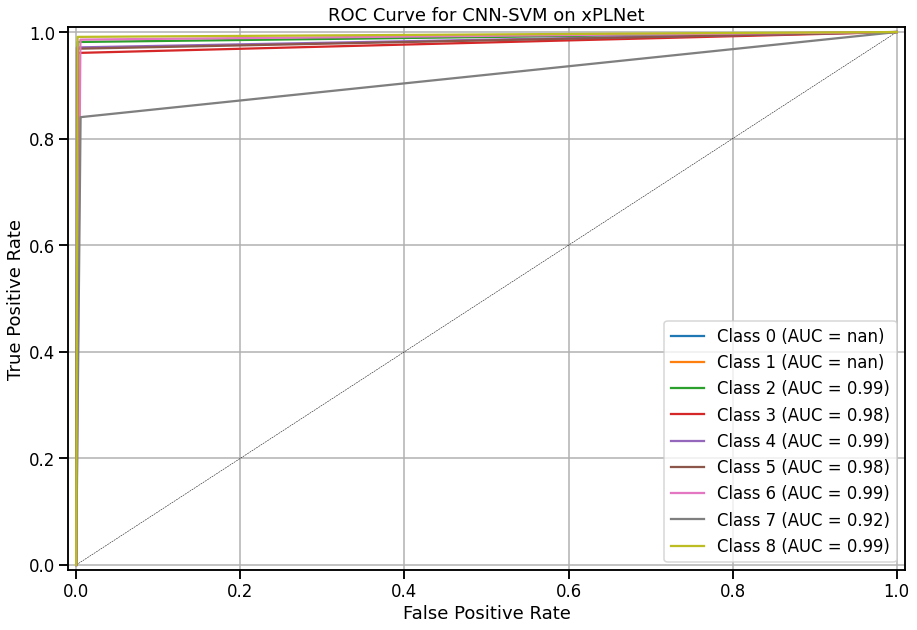

In [46]:
def plot_roc(y_test, y_pred_proba, model_name, dataset):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} on {dataset}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test = to_categorical(test_set.classes)
# Get predicted probabilities for test set
y_pred_proba = to_categorical(SVCM.predict(test_features))

# Plot ROC curve
plot_roc(y_test, y_pred_proba, "CNN-SVM", "xPLNet")

##### CNN-SOFTMAX

c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Jesriel John Saramba\Documents\CpE-Related Files\Python\Data Science\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


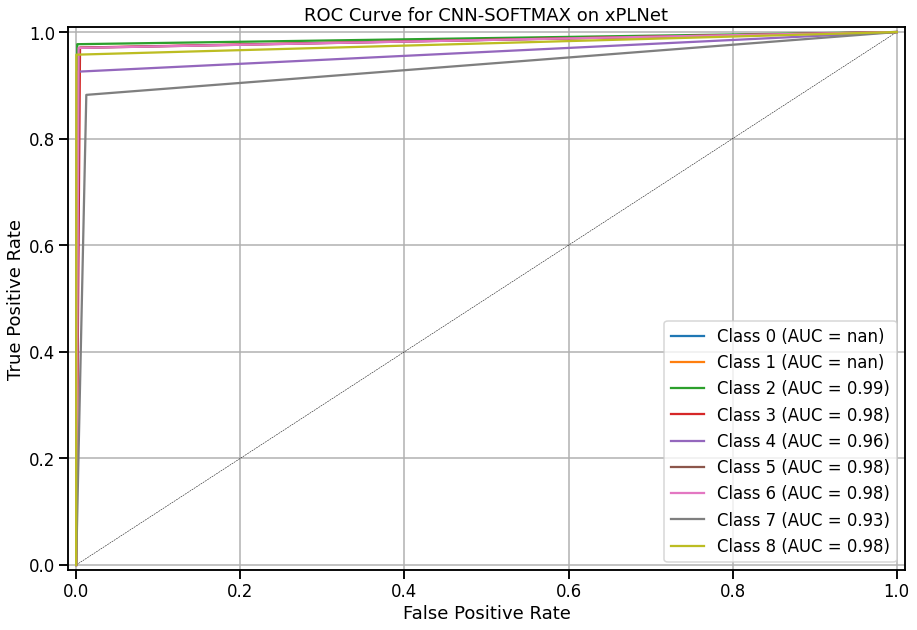

In [43]:
def plot_roc(y_test, y_pred_proba, model_name, dataset):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=.5)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} on {dataset}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test = to_categorical(test_set.classes)
# Get predicted probabilities for test set
y_pred_proba = to_categorical(CNNPred)

# Plot ROC curve
plot_roc(y_test, y_pred_proba, "CNN-SOFTMAX", "xPLNet")

#### Confusion Matrix

##### CNN-SVM

Text(0.5, 1.0, 'CNN-SVM Confusion Matrix')

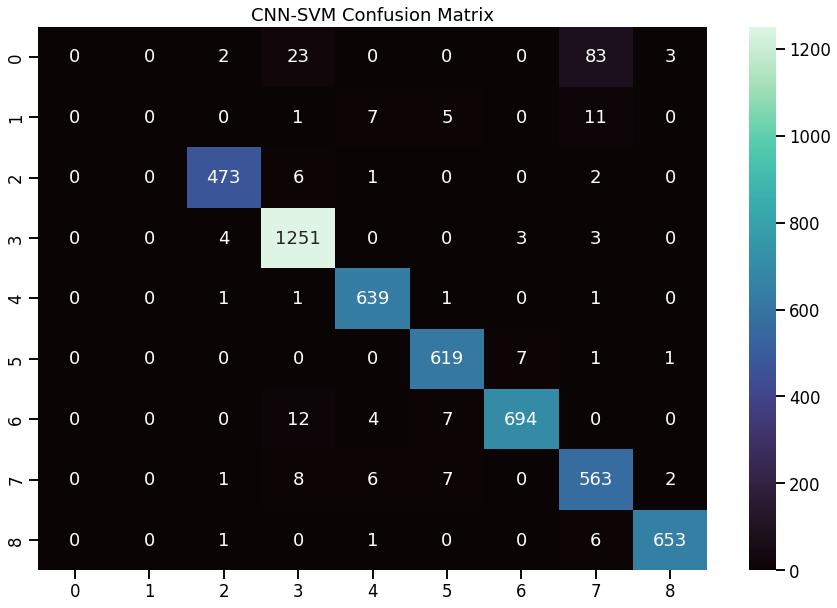

In [30]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(SVCMPred, test_set.classes), annot=True, fmt='d', cmap='mako').set_title("CNN-SVM Confusion Matrix")

##### CNN-SOFTMAX

Text(0.5, 1.0, 'CNN-SOFTMAX Confusion Matrix')

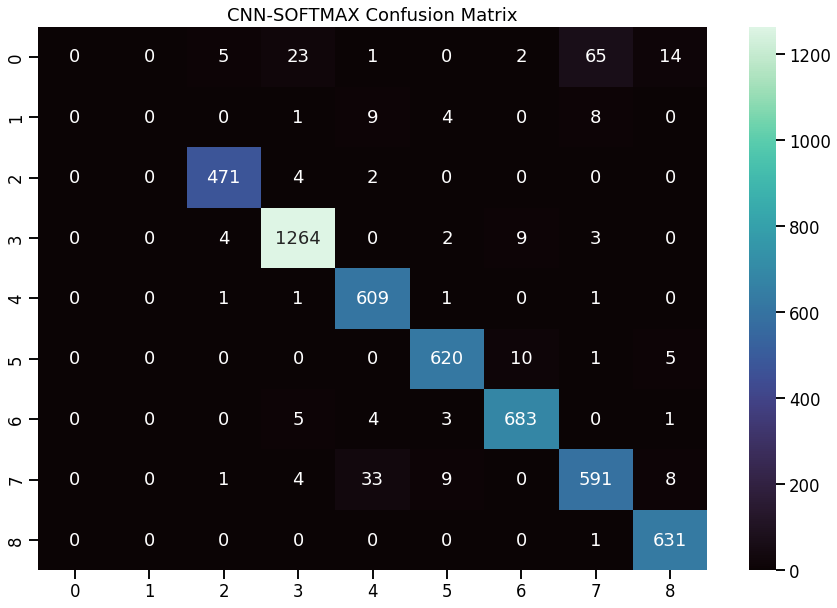

In [45]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(CNNPred, test_set.classes), annot=True, fmt='d', cmap='mako').set_title("CNN-SOFTMAX Confusion Matrix")

The results of CNN-Softmax and CNN-SVM on the image classification of plant stress are as follows: 95.209,95.659, which showed very little difference on the performance where SVM has higher accuracy. This is in line with the study conducted by Tang (2019) on an architecture that combines both CNN and SVM for image classification.  The test accuracies of CNN-Softmax and CNN-SVM are almost identical.  Liu and Ye (2018) on the other hand, showed that applying CNN-SVM on Gait-based gender recognition showed a better performance than having softmax. 

References:<br>
https://ieeexplore.ieee.org/document/8623118<br>
https://www.arxiv-vanity.com/papers/1712.03541/<br>
